In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the Oxford Pets Dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
train_data = dataset['train']
test_data = dataset['test']

In [3]:
IMG_SIZE = 256  # Resize images to 128x128 for faster training

def normalize_img(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE))
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask

def load_image(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint['segmentation_mask']
    return normalize_img(input_image, input_mask)

In [4]:
# Apply the preprocessing function
# train_data = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
# test_data = test_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_data = dataset['train'].map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = dataset['test'].map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)

In [5]:
# # Batch and prefetch the data
# BATCH_SIZE = 32
# train_data = train_data.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_data = test_data.batch(BATCH_SIZE)

In [6]:
# Model Development

# def unet_model(output_channels):
#     inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

#     # Encoder
#     down_stack = [
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(512, (3, 3), activation='relu', padding='same')
#     ]

#     x = inputs
#     skips = []
#     for down in down_stack:
#         x = down(x)
#         skips.append(x)
#     skips = reversed(skips[:-1])

#     # Decoder
#     up_stack = [
#         layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation='relu'),
#         layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'),
#         layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')
#     ]

#     for up, skip in zip(up_stack, skips):
#         x = up(x)
#         x = layers.Concatenate()([x, skip])

#     # Output Layer
#     output = layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(x)

#     return models.Model(inputs=inputs, outputs=output)


def unet(input_shape):
    inputs = layers.Input(input_shape)

    # Contracting Path
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Expanding Path
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)

    # Here is where you concatenate with the corresponding layer from the contracting path
    # Resize up5 if needed (assuming you want to match conv3)
    if up5.shape[1] != conv3.shape[1] or up5.shape[2] != conv3.shape[2]:
        up5 = layers.UpSampling2D(size=(2, 2))(up5)  # Ensure dimensions match

    # Now concatenate
    concat5 = layers.Concatenate()([up5, conv3])

    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    # Continue with the rest of the architecture...

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    if up6.shape[1] != conv2.shape[1] or up6.shape[2] != conv2.shape[2]:
        up6 = layers.UpSampling2D(size=(2, 2))(up6)

    concat6 = layers.Concatenate()([up6, conv2])
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    if up7.shape[1] != conv1.shape[1] or up7.shape[2] != conv1.shape[2]:
        up7 = layers.UpSampling2D(size=(2, 2))(up7)

    concat7 = layers.Concatenate()([up7, conv1])
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)  # Change to the number of classes if needed

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [7]:
# # Instantiate the model
# OUTPUT_CLASSES = 1
# model = unet_model(output_channels=1)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()

# Check shapes after preprocessing
for image, mask in train_data.take(1):
    print(f'Image shape: {image.shape}, Mask shape: {mask.shape}')

# Create and compile the U-Net model as before
input_shape = (256, 256, 3)  # Example input shape
model = unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(train_data, validation_data=test_data, epochs=3)

model.summary()

Image shape: (32, 256, 256, 3), Mask shape: (32, 256, 256, 1)
Epoch 1/3
115/115 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - accuracy: 0.0000e+00 - loss: 0.1123 - val_accuracy: 0.0000e+00 - val_loss: 0.0432
Epoch 2/3
115/115 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.0000e+00 - loss: 0.0425 - val_accuracy: 0.0000e+00 - val_loss: 0.0425
Epoch 3/3
115/115 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0425


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 128)  │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 23,092,037 (88.09 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,394,692 (58.73 MB)

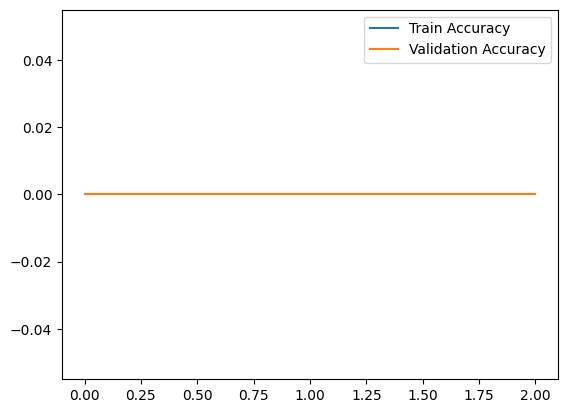

In [8]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [9]:
# Predicting vizualisations

def display_predictions(dataset, model, num=5):
    plt.figure(figsize=(15, 15))
    for images, masks in dataset.take(num):
        preds = model.predict(images)
        for i in range(num):
            plt.subplot(num, 3, i * 3 + 1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(num, 3, i * 3 + 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.title("True Mask")
            plt.axis("off")

            plt.subplot(num, 3, i * 3 + 3)
            plt.imshow(preds[i].squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


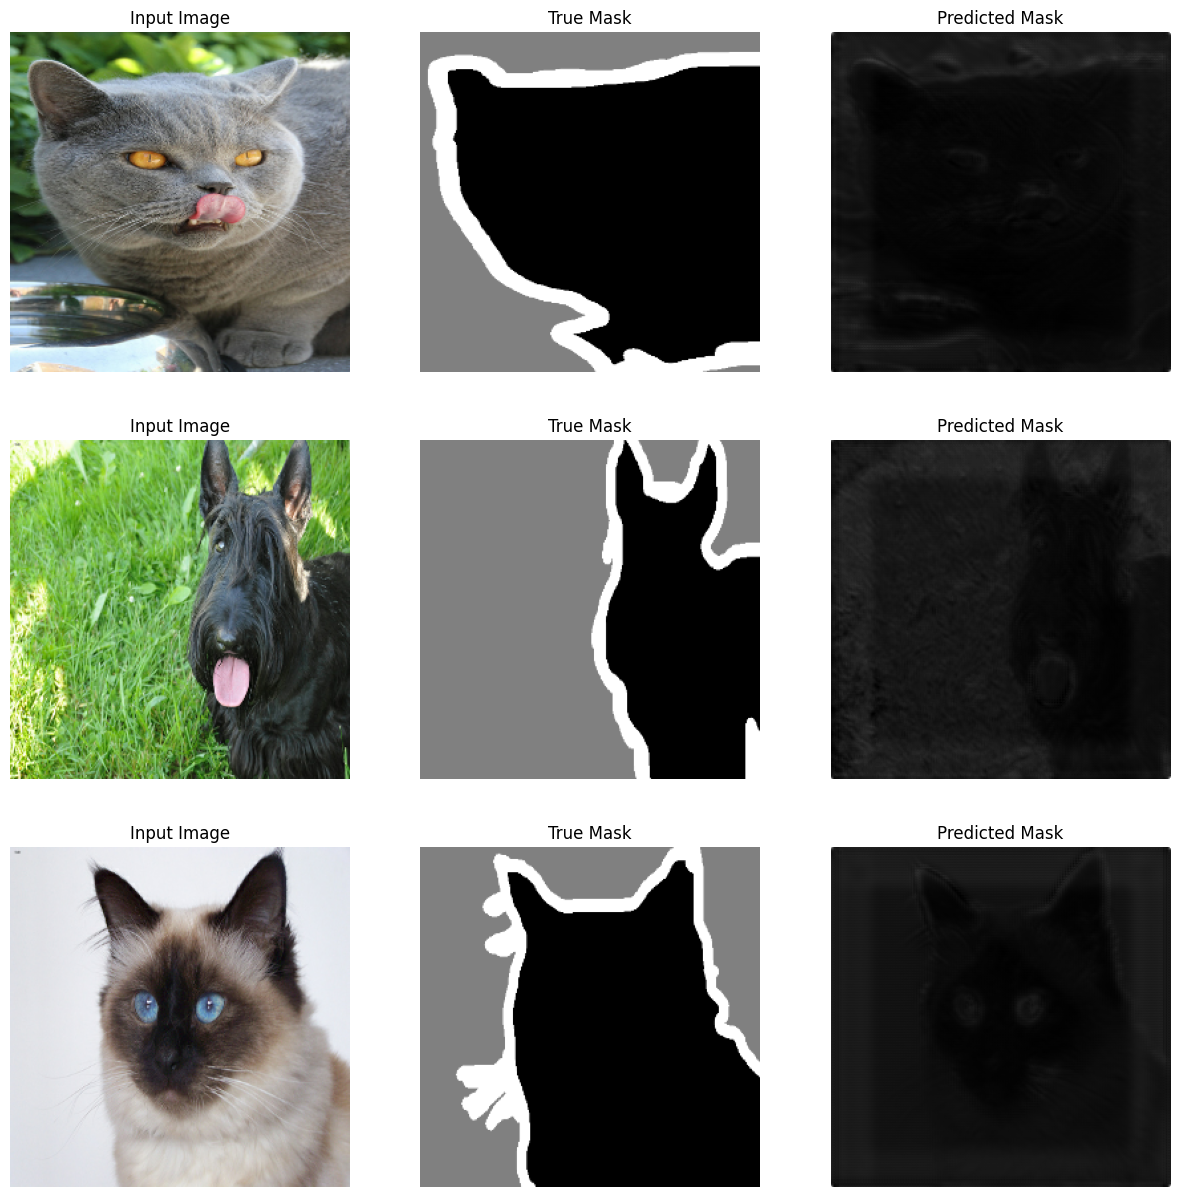

In [10]:
# Display sample predictions
display_predictions(test_data, model, num=3)